In [17]:
using LsqFit
using Plots
using StatsBase
push!(LOAD_PATH,"../../package/Meteor/src")
using Meteor
using DelimitedFiles

In [18]:
function SPTmodel(N::Real,J::Real,h1::Real,h2::Real)
    H=QubitsOperator()
    for i in 1:N-2
        H+=QubitsTerm(i=>"Z", i+1=>"X",i+2=>"Z", coeff=-J)
    end
    for i in 1:N
        H+=QubitsTerm(i=>"X",coeff=-h1)
    end
    for i in 1:N-1
        H+=QubitsTerm(i=>"X",i+1=>"X",coeff=-h2)
    end
    return H
end

function solver_SPTmodel(N::Real,J::Real,h1::Real,h2::Real)
    H=SPTmodel(N,J,h1,h2)
    e,v=ground_state(H)
    return e,v
end


solver_SPTmodel (generic function with 1 method)

In [19]:
h1_vals = [0.1000, 0.2556, 0.4111, 0.5667, 0.7222, 0.8778, 1.0333, 1.1889, 1.3444, 1.5000]
anti = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154,  -1.225, -1.285, -1.35]
para = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531]

10-element Vector{Float64}:
  0.8439
  0.6636
  0.5033
  0.3631
  0.2229
  0.09766
 -0.02755
 -0.1377
 -0.2479
 -0.3531

In [20]:
f(xs,p)=p[1]*xs.^3 +p[2]*xs.^2 +p[3].*xs .+p[4]
p0=[0.5,0.5,0.5,0.5]
f1=curve_fit(f,h1_vals,anti,p0)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.004954749146027968, -0.18186715980523027, 0.028307625884292413, -1.0028475141954523], [0.002169531544070624, -0.006510976060997153, 0.002397859199548602, 0.004689720841482892, 0.003605636613698282, -0.005782437195667178, -0.008312033331999924, 0.007067652709032757, 0.003539952243933664, -0.002864906562937364], [0.0010000000031037102 0.010000000012702839 0.09999999999868853 0.9999999999994726; 0.016698695614761786 0.06533135999922994 0.255600000004935 0.9999999999994726; … ; 2.4298838323845287 1.8074113600012005 1.34440000001075 0.9999999999994726; 3.3750000000061573 2.2499999999979936 1.5000000000169966 0.9999999999994726], true, Float64[])

In [21]:
p0=[0.5,0.5,0.5,0.5]
f1=curve_fit(f,h1_vals,anti,p0)
p1=[0.5,0.5,0.5,0.5]
f2=curve_fit(f,h1_vals,para,p1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([-0.07551616727581303, 0.35683566653076837, -1.2429268728246095, 0.962399433061855], [-0.0023004137225740573, 0.0031588622674207922, 0.0031919153903345876, -0.004213418148880876, -0.0004719852053741702, -0.002425327863813581, 0.0033154705285176993, -0.00013928083915909495, 0.000761868630228868, -0.0008776910366991575], [0.0009999999939365781 0.010000000003535707 0.10000000000427887 1.0000000000052196; 0.016698695614761786 0.06533135999922994 0.2556000000044169 1.0000000000052196; … ; 2.429883832402863 1.807411359982866 1.3444000000050416 1.0000000000052196; 3.3750000000061573 2.249999999979659 1.4999999999978042 1.0000000000052196], true, Float64[])

In [22]:
xs=LinRange(0,1.6,400)
ys1=f(xs,f1.param);
ys2=f(xs,f2.param);

In [23]:
Samples=400
dataset=zeros(2,Samples)
labels =zeros(2,Samples)
J=1
interval=0.01
while J<Samples
    h1=sample(LinRange(0,1.6,64))
    h2=sample(LinRange(-1.6,1.6,64))
    tmp1=h2-f(h1,f1.param)
    tmp2=h2-f(h1,f2.param)
    if tmp2>interval
        dataset[:,J]=[h1,h2]
        labels[:,J]=[1,0]
        J+=1
    elseif tmp2<-interval && tmp1>interval
        dataset[:,J]=[h1,h2]
        labels[:,J]=[0,1]
        J+=1
    elseif tmp1<-interval
        dataset[:,J]=[h1,h2]
        labels[:,J]=[1,0]
        J+=1
    end
end

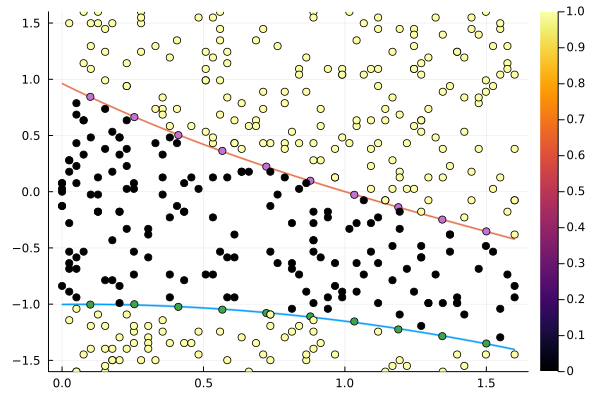

In [24]:
plot(xs,[ys1,ys2],ribbon=[0.01,0.01])
plot!(st=:scatter,h1_vals,[anti,para],ylims=(-1.6,1.6))
plot!(st=:scatter,dataset[1,:],dataset[2,:],zcolor=labels[1,:],legend=false)

In [25]:
global N=15
h1=dataset[1,:]
h2=dataset[2,:]
J=1
eigenvalues=zeros(Samples)
eigenstates=zeros(2^N,Samples)
for i in 1:Samples
    H=SPTmodel(N,J,h1[i],h2[i])
    e,v=ground_state(H)
    eigenvalues[i]=e
    eigenstates[:,i]=v
end


writedlm("SPT_train_set_$(N)_$(Samples)_$(interval).csv",eigenstates,',')
writedlm("SPT_train_label_$(N)_$(Samples)_$(interval).csv",labels,',')

#生成测试集
# h1=LinRange(0,1.6,128)
# h2=LinRange(-1.6,1.6,128)
# eigenvalues=zeros(128^2)
# eigenstates=zeros(2^N,128^2)
# for i in 1:128
#     for j in 1:128
#         H=SPTmodel(N,J,h1[i],h2[j])
#         e,v=ground_state(H)
#         eigenvalues[i*j]=e
#         eigenstates[:,(i-1)*128+j]=v
#     end
# end

# writedlm("SPT_test_set_$(N)_128.csv",eigenstates,',')